In [26]:
from pathlib import Path
import sys
sys.path.insert(0, str(Path().absolute().parent))

import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, metrics

from data.datasets import PureCompoundsInTallCuvettes, COLOR_DICT
from data.data_functions import DataLoader, DerivTransform, NormalizeTransform, StaticShiftTransform
from data.plot_functions import plot_array_data, plot_confusion_matrix
from data.utils import train_test_split, sort_by_set

SEED = 4401

In [27]:

exp_set = PureCompoundsInTallCuvettes()
train_set, test_set = train_test_split(exp_set, seed=SEED)

## Temporal analysis

Load data

In [28]:
psi_derivs, labels = DataLoader(exp_set, transforms=[DerivTransform, NormalizeTransform]).load()

Loading experimental data
(1/11) Pentane (9 exp.): [===================0] 100% complete
(2/11) Hexane (10 exp.): [===================0] 100% complete
(3/11) Heptane (3 exp.): [===================0] 100% complete
(4/11) Octane (8 exp.): [===================0] 100% complete
(5/11) Nonane (5 exp.): [===================0] 100% complete
(6/11) Decane (7 exp.): [===================0] 100% complete
(7/11) Ethanol (7 exp.): [===================0] 100% complete
(8/11) Water (7 exp.): [===================0] 100% complete
(9/11) Acetone (8 exp.): [===================0] 100% complete
(10/11) Toluene (7 exp.): [===================0] 100% complete
(11/11) Acetonitrile (5 exp.): [===================0] 100% complete
Length of experimental set loaded: 76


#### Calculate SVM

In [29]:
def predict(SVC, test, lbl):
    predicted = SVC.predict(test)
    print("Validation accuracy: " + str(round(np.sum(predicted == lbl)/float(len(lbl)),3)) + " (" + str(np.sum(predicted == lbl)) + "/" + str(len(lbl)) + ")")

    # list scores
    print("Accuracy: " + str(round(metrics.accuracy_score(lbl, predicted),3)))
    print("Precision: " + str(round(metrics.recall_score(lbl, predicted, average="macro"),3)))
    print("F1 Score: " + str(round(metrics.f1_score(lbl, predicted, average="macro"),3)))

    return predicted

In [30]:
train_data, train_lbl, test_data, test_lbl = sort_by_set(psi_derivs, train_set, test_set)

In [31]:
SVC = svm.SVC(C=10,gamma=10, kernel="rbf")
SVC.fit(train_data, train_lbl)
print("Training accuracy: " + str(SVC.score(train_data, train_lbl)) + " (" + str(len(train_data)) + ")")

Training accuracy: 0.98 (50)


In [32]:
predicted = predict(SVC, test_data, test_lbl)
print(f"\nMismatches (true, pred): {[(lbl, pred) for lbl,pred in (zip(test_lbl, predicted)) if lbl!=pred]}")

Validation accuracy: 0.885 (23/26)
Accuracy: 0.885
Precision: 0.894
F1 Score: 0.885

Mismatches (true, pred): [('Pentane', 'Nonane'), ('Octane', 'Nonane'), ('Acetonitrile', 'Ethanol')]


#### Plot

Validation accuracy: 0.885 (23/26)
Accuracy: 0.885
Precision: 0.894
F1 Score: 0.885


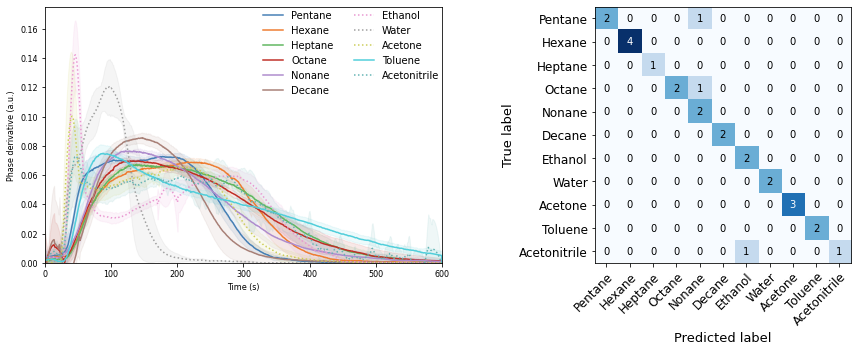

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

linestyle_dict = dict([
    ('Pentane', '-'),
    ('Hexane', '-'),
    ('Heptane', '-'),
    ('Octane', '-'),
    ('Nonane', '-'),
    ('Decane', '-'),
    ('Ethanol', ':'),
    ('Water', ':'),
    ('Acetone', ':'),
    ('Toluene', '-'),
    ('Acetonitrile', ':')
])

plot_array_data(exp_set, psi_derivs, [0,600], ylim=[0,0.175], color_dict=COLOR_DICT, linestyle=linestyle_dict, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=2, frameon=False, shadow=False)

#from IPython.utils import io
#with io.capture_output() as captured:
plot_confusion_matrix(test_lbl, predict(SVC, test_data, test_lbl), classes=list(exp_set.keys()), ax=axes[1])

plt.tight_layout()

## Static analysis

Load data

In [40]:
static_shift, labels = DataLoader(exp_set, transforms=[StaticShiftTransform()]).load()

Loading experimental data
(1/11) Pentane (9 exp.): [===================0] 100% complete
(2/11) Hexane (10 exp.): [===================0] 100% complete
(3/11) Heptane (3 exp.): [===================0] 100% complete
(4/11) Octane (8 exp.): [===================0] 100% complete
(5/11) Nonane (5 exp.): [===================0] 100% complete
(6/11) Decane (7 exp.): [===================0] 100% complete
(7/11) Ethanol (7 exp.): [===================0] 100% complete
(8/11) Water (7 exp.): [===================0] 100% complete
(9/11) Acetone (8 exp.): [===================0] 100% complete
(10/11) Toluene (7 exp.): [===================0] 100% complete
(11/11) Acetonitrile (5 exp.): [===================0] 100% complete
Length of experimental set loaded: 76


#### Calculate SVM

In [41]:
train_data, train_lbl, test_data, test_lbl = sort_by_set(static_shift, train_set, test_set)

In [42]:
SVC = svm.SVC(C=10,gamma=10, kernel="rbf")
SVC.fit(train_data, train_lbl)
print("Training accuracy: " + str(SVC.score(train_data, train_lbl)) + " (" + str(len(train_data)) + ")")

Training accuracy: 0.78 (50)


In [43]:
predicted = predict(SVC, test_data, test_lbl)
print(f"\nMismatches (true, pred): {[(lbl, pred) for lbl,pred in (zip(test_lbl, predicted)) if lbl!=pred]}")

Validation accuracy: 0.308 (8/26)
Accuracy: 0.308
Precision: 0.303
F1 Score: 0.256

Mismatches (true, pred): [('Pentane', 'Ethanol'), ('Pentane', 'Acetone'), ('Hexane', 'Ethanol'), ('Hexane', 'Pentane'), ('Hexane', 'Octane'), ('Hexane', 'Ethanol'), ('Heptane', 'Acetone'), ('Nonane', 'Acetone'), ('Nonane', 'Decane'), ('Ethanol', 'Acetone'), ('Ethanol', 'Acetone'), ('Water', 'Ethanol'), ('Water', 'Acetone'), ('Acetone', 'Water'), ('Acetone', 'Decane'), ('Acetone', 'Octane'), ('Acetonitrile', 'Ethanol'), ('Acetonitrile', 'Acetone')]


#### Plot

Validation accuracy: 0.308 (8/26)
Accuracy: 0.308
Precision: 0.303
F1 Score: 0.256


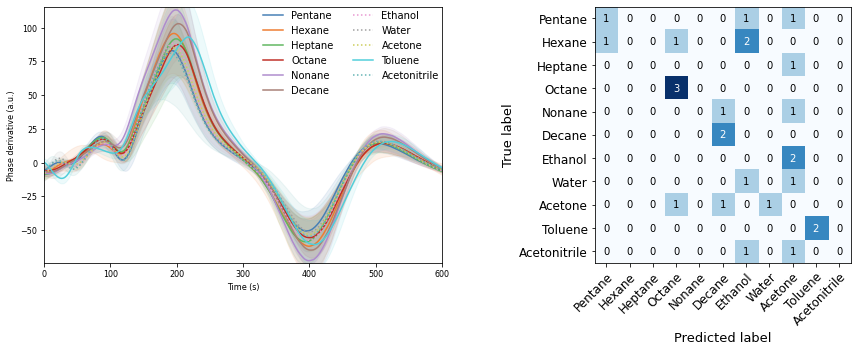

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

linestyle_dict = dict([
    ('Pentane', '-'),
    ('Hexane', '-'),
    ('Heptane', '-'),
    ('Octane', '-'),
    ('Nonane', '-'),
    ('Decane', '-'),
    ('Ethanol', ':'),
    ('Water', ':'),
    ('Acetone', ':'),
    ('Toluene', '-'),
    ('Acetonitrile', ':')
])

plot_array_data(exp_set, static_shift, [0,600], color_dict=COLOR_DICT, linestyle=linestyle_dict, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=2, frameon=False, shadow=False)

#from IPython.utils import io
#with io.capture_output() as captured:
plot_confusion_matrix(test_lbl, predict(SVC, test_data, test_lbl), classes=list(exp_set.keys()), ax=axes[1])

plt.tight_layout()